In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

<h1>MULTI-LAYER PERCEPTRON NEURAL NETWORK V2</h1>

inspiration: A Neural Probabilistic Language Model, Yoshua Bengio

character-level language model

model initialization and normalization

In [2]:
# read in words
words = open('../data/names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
string_to_index = {s : i + 1 for i, s in enumerate(chars)}
string_to_index['.'] = 0
index_to_string = {i : s for s, i in string_to_index.items()}
vocab_size = len(index_to_string)
len(words)

32033

In [4]:
# build dataset

block_size = 3 # context length

def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for character in word + '.':
            index_x = string_to_index[character]
            X.append(context)
            Y.append(index_x)
            context = context[1:] + [index_x]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80%
X_dev, Y_dev = build_dataset(words[n1:n2]) # 10%
X_test, Y_test = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embed = 10 # the dimensionality of the charecter embedding vectors
n_hidden = 200 # number of neurons in hidden layer

# normalize initial values to prevent dead tanh neurons and extreme logit values
generator = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed)            , generator = generator)
W1 = torch.randn((n_embed * block_size, n_hidden), generator = generator) * (5/3) / ((n_embed * block_size)** 0.5)
# b1 = torch.randn(n_hidden,                       generator = generator) * 0.01 (get rid of bias as it is removed during batch normalization)
W2 = torch.randn((n_hidden, vocab_size),           generator = generator) * 0.01 
b2 = torch.randn(vocab_size,                       generator = generator) * 0

batch_normal_gain = torch.ones((1, n_hidden))
batch_normal_bias = torch.zeros((1, n_hidden)) 

batch_normal_std_running = torch.ones((1, n_hidden))
batch_normal_mean_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2]
print(sum(parameter.nelement() for parameter in parameters))
for parameter in parameters:
    parameter.requires_grad = True

11697


tensor(0.0005) tensor(0.9990)
tensor(0.0017) tensor(1.0279)


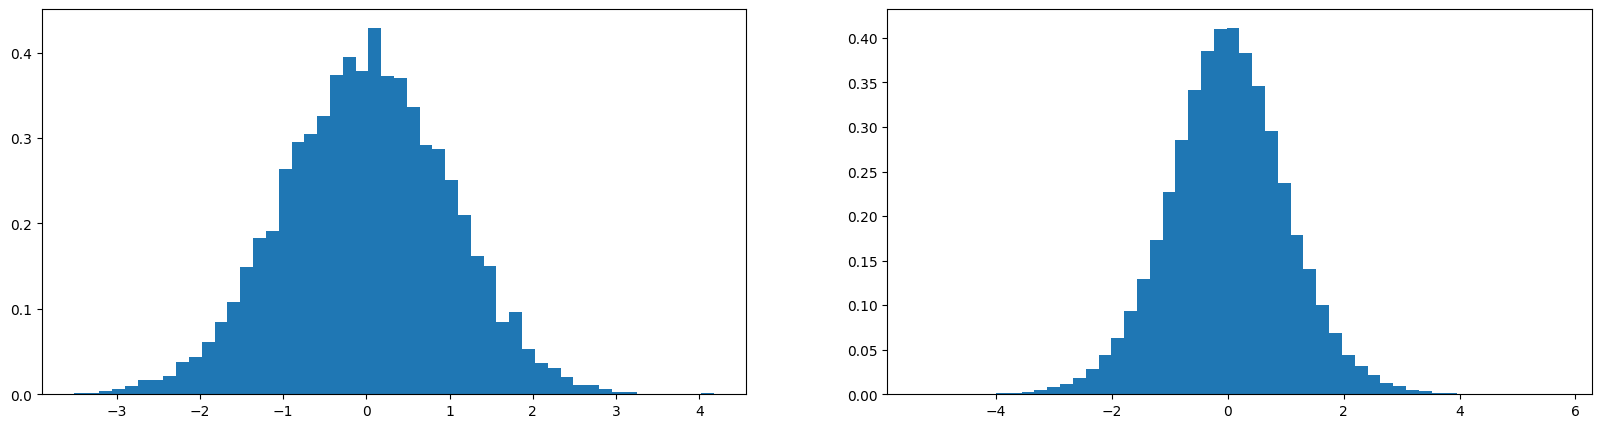

In [6]:
# example of layers expanding an inputs gaussian distribution
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [7]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    index_x = torch.randint(0, X_train.shape[0], (batch_size,), generator = generator)
    X_batch, Y_batch = X_train[index_x], Y_train[index_x] # batch X, Y

    # forward pass
    embed = C[X_batch]
    embed_concat = embed.view(embed.shape[0], -1) # concatenate the vectors
    # linear layer
    hidden_preact = embed_concat @ W1 # + b1  hidden layer pre-activation

    # batch norm layer
    batch_normal_mean_i = hidden_preact.mean(0, keepdim=True) # ith batch's mean
    batch_normal_std_i = hidden_preact.std(0, keepdim=True) # ith batch's std deviation
    hidden_preact = batch_normal_gain * (hidden_preact - batch_normal_mean_i) / batch_normal_std_i + batch_normal_bias # normalize hpreact neurons to unit gaussian for batch (batch normalization)
    # keep track of running mean/std to use during inference and evaluation
    with torch.no_grad(): 
        batch_normal_mean_running = 0.999 * batch_normal_mean_running + 0.001 * batch_normal_mean_i
        batch_normal_std_running = 0.999 * batch_normal_std_running + 0.001 * batch_normal_std_i


    # non-linearity
    hidden_layer = torch.tanh(hidden_preact)
    logits = hidden_layer @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # loss function

    #backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # update
    learning_rate = 0.1 if i < 100000 else 0.01 #learning rate decay
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/ {max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())    


      0/  200000: 3.3239


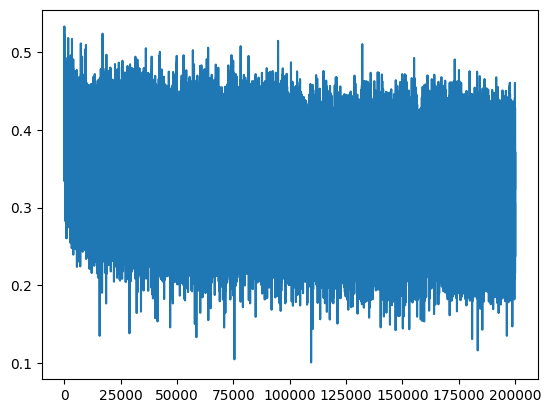

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'development': (X_dev, Y_dev),
        'test': (X_test, Y_test),
    }[split]
    embed = C[x] # (N, block_size, n_embd)
    embed_concat = embed.view(embed.shape[0], -1) # concat into (N, block_size * n_embd)
    hidden_preact = embed_concat @ W1  # hidden layer pre-activation
    hidden_preact = batch_normal_gain * (hidden_preact - batch_normal_mean_running) / batch_normal_std_running + batch_normal_bias # normalize hpreact neurons to unit gaussian for batch (batch normalization)
    hidden_layer = torch.tanh(hidden_preact) # (N, n_hidden)
    logits = hidden_layer @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('development')

train 2.0779716968536377
development 2.112131357192993


In [ ]:
# sample from the model 
generator = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        # forward pass neural net
        embed = C[torch.tensor([context])]
        hidden_preact = embed.view(1, -1) @ W1
        hidden_preact = batch_normal_gain * (hidden_preact - batch_normal_mean_running) / batch_normal_std_running + batch_normal_bias
        hidden_layer = torch.tanh(hidden_preact)
        logits = hidden_layer @ W2 + b2
        probabilities = F.softmax(logits, dim = 1)

        # sample from distribution
        index_x = torch.multinomial(probabilities, num_samples=1, generator=generator).item()

        # shit context window
        context = context[1:] + [index_x]
        out.append(index_x)

        # if we sample '.' token, break
        if index_x == 0:
            break
    print(''.join(index_to_string[index] for index in out))

carmahxate.
hari.
kimri.
reity.
salaysie.
mahnen.
delynn.
jareei.
nellara.
chaiivon.
leigh.
ham.
jocn.
quinthonor.
marianni.
watell.
dearynix.
kaellissa.
med.
edi.
